In [3]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import getpy as gp
import torch
import torchsparse
import hdbscan
import laspy
import time
import itertools

from EHydro_TreeUnet.tree_unet import UNet
from pathlib import Path
from collections import deque

from torch import nn
from torch.cuda import amp
from torchsparse import SparseTensor
from torchsparse.nn import functional as F
from torch.utils.data import random_split, DataLoader
from torchsparse.utils.collate import sparse_collate_fn
from torchsparse.utils.quantize import sparse_quantize
from torchsparse.utils.collate import sparse_collate_fn as _orig_collate

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
TRAINING = True

DATA_AUGMENTATION_COEF = 1.5
SEMANTIC_LOSS_COEF = 0.5
PARENT_LOSS_COEF = 0.5

In [19]:
class FORinstanceDataset:
    def __init__(self, voxel_size: float) -> None:
        self.voxel_size = voxel_size
        self.folder = Path('./datasets/FORinstance')
        self.extensions = ('.laz', '.las')
        self.files = sorted(
            [f for f in self.folder.rglob("*") if f.is_file() and f.suffix.lower() in self.extensions],
            key=lambda f: f.name
        )

        self.files = [self.files[i % len(self.files)] for i in range(int(len(self.files) * DATA_AUGMENTATION_COEF))]

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return [self._load_file(self.files[i]) for i in range(*idx.indices(len(self)))]
        elif isinstance(idx, int):
            if idx < 0:
                idx += len(self)
            if idx < 0 or idx >= len(self):
                raise IndexError("Index out of range")
            return self._load_file(self.files[idx])
        else:
            raise TypeError("Index must be a slice or an integer")
        
    def _encode_offset(self, offset):
        idx = (offset[0] + 1) * 9 + (offset[1] + 1) * 3 + (offset[2] + 1)
        return idx
    
    def _bfs_voxel_tree_array(self, points, root):
        N = points.shape[0]
        point_index = {tuple(p): i for i, p in enumerate(points)}
        voxel_set = set(point_index.keys())

        labels = np.full(N, fill_value=27, dtype=np.int32)

        visited = set()
        queue = deque()

        queue.append(root)
        visited.add(root)
        labels[point_index[root]] = self._encode_offset((0, 0, 0))

        directions = [np.array(d) for d in itertools.product([-1, 0, 1], repeat=3) if d != (0, 0, 0)]
        while queue:
            current = np.array(queue.popleft())

            for d in directions:
                neighbor = tuple(current + d)
                if neighbor in voxel_set and neighbor not in visited:
                    visited.add(neighbor)
                    neighbor_idx = point_index[neighbor]
                    offset = tuple(-d)
                    labels[neighbor_idx] = self._encode_offset(offset)
                    queue.append(neighbor)

        return labels
    
    def _load_file(self, path):
        las = laspy.read(path)

        coords = np.vstack((las.x, las.y, las.z)).transpose()
        coords -= np.min(coords, axis=0, keepdims=True)
        feat = np.vstack((las.intensity, las.return_number, las.number_of_returns)).transpose()
        label = np.array(las.classification)
        instance_ids = np.array(las.treeID)

        mask = label != 3

        coords = coords[mask]
        feat = feat[mask]
        label = label[mask]
        label = np.where(label > 3, label - 1, label)
        instance_ids = instance_ids[mask]
        
        coords, indices = sparse_quantize(coords, self.voxel_size, return_index=True)
        feat = feat[indices]
        label = label[indices]
        instance_ids = instance_ids[indices]

        now = time.time()
        offset = np.zeros(coords.shape[0], dtype=np.float32)
        unique_ids = np.unique(instance_ids)
        for inst_id in unique_ids:
            mask = instance_ids == inst_id
            if not np.any(mask):
                continue

            tree_points = coords[mask]
            centroid = tree_points.mean(axis=0)
            distances = np.linalg.norm(tree_points - centroid, axis=1)
            root_idx = np.argmin(distances)
            tree_offsets = self._bfs_voxel_tree_array(tree_points, tuple(tree_points[root_idx]))
            offset[mask] = tree_offsets

        coords = torch.tensor(coords, dtype=torch.int)
        feat = torch.tensor(feat.astype(np.float32), dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)
        offset = torch.tensor(offset, dtype=torch.long)

        input = SparseTensor(coords=coords, feats=feat)
        label = SparseTensor(coords=coords, feats=label)
        offset = SparseTensor(coords=coords, feats=offset)
        print(f'Preprocesado: {time.time() - now}')
        return {"input": input, "label": label, "offset": offset}

    def __len__(self):
        return len(self.files)

In [ ]:
colormap = np.array([
    [255, 0, 0],    # clase 0 - Unclassified - rojo
    [0, 255, 0],    # clase 1 - Low-vegetation - verde
    [128, 128, 128],# clase 2 - Terrain - gris
    [255, 165, 0],  # clase 3 - Stem - naranja
    [0, 128, 0],  # clase 4 - Live-branches - verde oscuro
    [0, 0, 255]     # clase 5 - Woody-branches - azul
], dtype=np.uint8)

def draw_pc(coords, ids):
    pcd = o3d.geometry.PointCloud()

    #colors = colormap[labels]
    #colors = colors / 255.0
    
    #pcd.points = o3d.utility.Vector3dVector(coords)
    #pcd.colors = o3d.utility.Vector3dVector(colors)

    #o3d.visualization.draw_geometries([pcd])

    unique_ids = np.unique(ids)
    n_instances = len(unique_ids)

    cmap = plt.get_cmap("tab20")  # Puedes cambiar a 'tab10', 'gist_ncar', etc.
    colors = np.array([cmap(i % 20)[:3] for i in range(n_instances)])

    id2color = {id_: colors[i] for i, id_ in enumerate(unique_ids)}
    point_colors = np.array([id2color[id_] for id_ in ids])

    pcd.colors = o3d.utility.Vector3dVector(point_colors)
    o3d.visualization.draw_geometries([pcd])

def segment_by_offsets(points, offset_classes):
    root_mask = offset_classes == 13
    base_mask = ~root_mask & (offset_classes != 27)
    base_idx = np.flatnonzero(base_mask)
    offset_table = np.array(list(np.ndindex((3, 3, 3)))) - 1
    instance_ids = np.full(points.shape[0], fill_value=-1, dtype=np.int8)

    roots = points[root_mask]
    base_points = points[base_mask]
    base_offsets = offset_table[offset_classes[base_mask]]

    parent_points = base_points + base_offsets
    for tree_id, root in enumerate(roots):
        parents = np.array([root])
        tree_mask = np.zeros(base_points.shape[0], dtype=bool)

        while parents.size > 0:
            print(parents.size)
            child_mask = np.isin(
                parent_points.view([('', parent_points.dtype)] * 3).reshape(-1),
                parents.view([('', parents.dtype)] * 3).reshape(-1)
            )

            parents = base_points[child_mask]
            tree_mask |= child_mask

        instance_ids[base_idx[tree_mask]] = tree_id

    return instance_ids



In [28]:
dataset = FORinstanceDataset(voxel_size=0.2)
input = dataset[0]

coord = input['input'].C.numpy()
offset = input['offset'].F.numpy()

instances = segment_by_offsets(coord, offset)

draw_pc(coord, instances)

Preprocesado: 10.232538938522339


KeyboardInterrupt: 

[step 1] loss = 9.793437004089355
[step 2] loss = 9.411683082580566
[step 3] loss = 12.975831985473633
[step 4] loss = 8.699515342712402
[step 5] loss = 11.189929962158203
[step 6] loss = 7.727526664733887
[step 7] loss = 8.325509071350098
[step 8] loss = 7.631495952606201
[step 9] loss = 8.12620735168457
[step 10] loss = 8.509062767028809
[step 11] loss = 8.915821075439453
[step 12] loss = 10.822931289672852
[step 13] loss = 8.568294525146484
[step 14] loss = 7.464605808258057
[step 15] loss = 12.446647644042969
[step 16] loss = 7.702928066253662
[step 17] loss = 7.744419574737549
[step 18] loss = 7.352845668792725
[step 19] loss = 7.964566230773926
[step 20] loss = 12.343476295471191
[step 21] loss = 8.269789695739746
[step 22] loss = 7.586459636688232
[step 23] loss = 8.565917015075684
[step 24] loss = 8.109920501708984
[step 25] loss = 8.453369140625
[step 26] loss = 8.065918922424316
[step 27] loss = 8.001216888427734
[step 28] loss = 8.445723533630371
[step 29] loss = 12.20019912

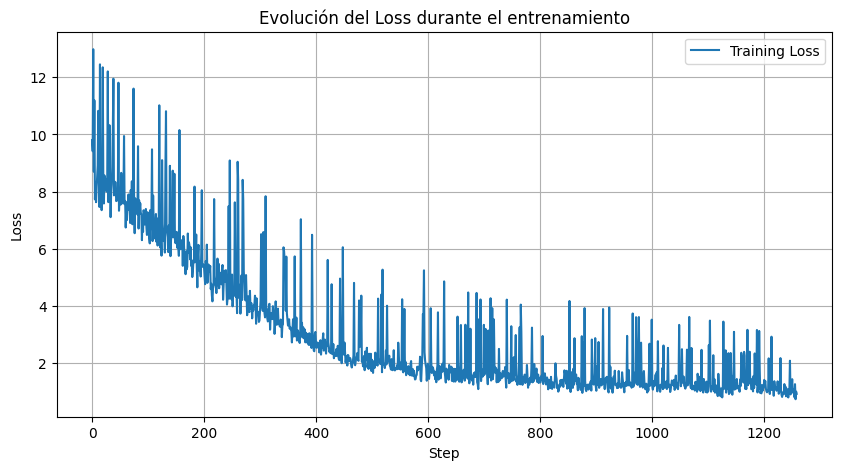

In [4]:
conv_config = F.conv_config.get_default_conv_config(conv_mode=F.get_conv_mode())
conv_config.kmap_mode = 'hashmap'
F.conv_config.set_global_conv_config(conv_config)

model = UNet(3, 6).to(device='cuda')

dataset = FORinstanceDataset(voxel_size=0.2)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, collate_fn=sparse_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=sparse_collate_fn)

criterion_semantic = nn.CrossEntropyLoss()
criterion_offset = nn.SmoothL1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler = amp.GradScaler(enabled=True)
losses = []

for k, feed_dict in enumerate(train_loader):
    inputs = feed_dict["input"].to(device='cuda')
    label = feed_dict["label"].to(device='cuda')
    offset = feed_dict["offset"].to(device='cuda')

    with amp.autocast(enabled=True):
        semantic_output, offset_output = model(inputs)
        
        loss_semantic = criterion_semantic(semantic_output.feats, label.feats)
        loss_offset = criterion_offset(offset_output.feats, offset.feats)
        loss = 0.2 * loss_semantic + 0.8 * loss_offset

    print(f"[step {k + 1}] loss = {loss.item()}")
    losses.append(loss.item())

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

plt.figure(figsize=(10, 5))
plt.plot(losses, label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Evolución del Loss durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# enable torchsparse 2.0 inference
model.eval()
# enable fused and locality-aware memory access optimization
torchsparse.backends.benchmark = True  # type: ignore

clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
with torch.no_grad():
    for k, feed_dict in enumerate(val_loader):
        inputs = feed_dict["input"].to(device='cuda')
        label = feed_dict["label"].to(device='cuda')
        offset = feed_dict["offset"].to(device='cuda')

        with amp.autocast(enabled=True):
            now = time.time()
            semantic_output, offset_output = model(inputs)
            print(f'duracion: {(time.time() - now):.2f} s')

            loss_semantic = criterion_semantic(semantic_output.feats, label.feats)
            loss_offset = criterion_offset(offset_output.feats, offset.feats)
            loss = 0.1 * loss_semantic + 0.9 * loss_offset

            coords = semantic_output.coords[:, 1:].cpu().numpy()
            semantic = semantic_output.feats.cpu()
            offset = offset_output.feats.cpu().numpy()
            label = torch.argmax(semantic, dim=1).numpy()

            #min_coords = np.min(coords, axis=0)
            #max_coords = np.max(coords, axis=0)
            #side_lengths = max_coords - min_coords
            #volume = np.prod(side_lengths)
            #offset = offset * (volume / 10)

            collapsed_coords = coords + offset
            id = clusterer.fit_predict(collapsed_coords)

            draw_pc(collapsed_coords, label, id)

        print(f"[inference step {k + 1}] loss = {loss.item()}")

duracion: 0.29 s
[inference step 1] loss = 1.8142627477645874
duracion: 0.04 s


KeyboardInterrupt: 